# Numerical tests

Import module from `nlc.py`.

In [1]:
from nlc import *

# plt.rcParams["font.family"] = "Latin Modern Roman"
plt.rcParams["mathtext.fontset"] = "cm"

First we define an initial region on a $128\times 128$ grid. The volume $\bar V_0$ is fixed at $0.04$.

In [2]:
N = 128
NN = 3 * N**2 - 8 * N + 6  # dimension of vector

# Initial shape (circle)
Xx, Yy = square_grid(N, centre=True)
r = .08
phi0 = 1.0 * (((Xx - 0.5)**2 + (Yy - 0.5)**2) < r**2)
phi0 = reinit(0.5 - phi0, 1. / N, 0.04) # meet volume constraint with SDF reinit

In [3]:
def test_min(conf, outdir, X0=None, maxiter=40000, eta=2e-3, phi0=None, P_only=False):
    N=conf['N']
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    if phi0 is None:
        # square
        Xx, Yy = square_grid(N, centre=True)
        r = .08
        phi0 = 1.0 * (((Xx - 0.5)**2 + (Yy - 0.5)**2) < r**2)
        phi0 = reinit(0.5 - phi0, 1. / N, conf['vol']) # meet volume constraint with SDF reinit
        
    # Update config
    save_lc_config(outdir+os.sep+"params.json", conf)
    # Functional object
    FF = LCFunc()
    FF.reset_conf(conf)

    # Initial value (if exists)
    state_f = outdir+os.sep+"solution.npy"
    if os.path.exists(state_f):
        # Load directly
        print("Loading state file saved last time...", flush=True)
        X = load_lc(state_f, N)   
    elif X0 is not None:
        # Designated initial value
        X = LCState(N, X0.x)     
    else:
        print("Initialize new state",flush=True)
        x0 = np.zeros(3 * N**2 - 8 * N + 6)
        # x0 = np.random.randn(3*N**2-8*N+6)/np.sqrt(3*N**2)  # random init
        X = view_as_lc(x0, N)
        X.phi[:] = phi0[1:N - 1, 1:N - 1]  # Initial region
        # X.phi[:] += conf['vol']*(N/(N-2))**2-np.average(X.phi)  # just a simple shift

    # Minimize
    X, _ = FF.grad_descent(X, maxiter=maxiter, eta=eta, tol=1e-8, verbose=True, bb=True, inspect=False)
    np.save(state_f, X.x)

    # Plot
    fig = plt.figure(num=1)
    fig.clf()
    if P_only:
        fig.set(figwidth=4.8,figheight=3.6)
        ax = fig.subplots(1,1)
        plot_P(X,ax=ax,scale=3.0,density=0.1,phi_form="bound",energy=FF.energy(X))
    else:
        fig.set(figwidth=9.6,figheight=3.6)
        plot_state(X, fig, scale=3.0, density=0.1, phi_form="bound", energy=FF.energy(X))
    fig.savefig(outdir+".pdf")
    return X

## Minimization

Demo case. Fix $V_0=0.04,\varepsilon_r=0.005$.

Radial solution when
$$\lambda=2\times 10^{-7}, w_v=6\times 10^{14}, w_p=3\times 10^8, w_a=9\times 10^8.$$

Loading state file saved last time...
Iteration failed to converge, |g| = 2.935945223301571e-05


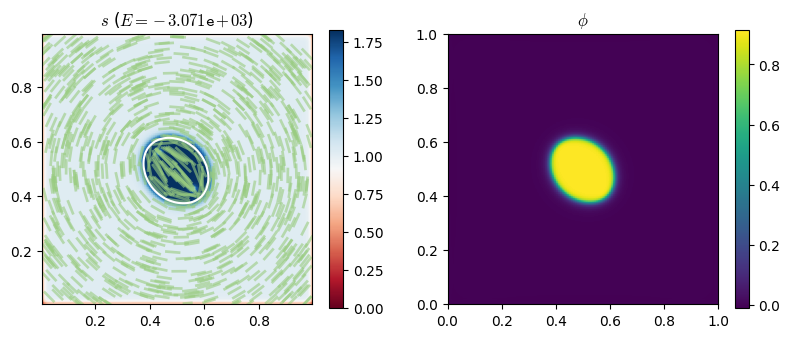

In [11]:
# Configs
# B,C,L are set by default
c0 = LCConfig(N=N, lam=2e-5, epsr=.005, vol=.09,
                 wv=1e14, wphi=3e7, wa=6e8)

X = test_min(c0, "test", maxiter=40000, eta=2e-3, phi0=phi0)

# fig=plt.figure()
# ax=fig.add_subplot(projection="3d")
# ax.plot_surface(Xx[1:N-1,1:N-1],Yy[1:N-1,1:N-1],X.phi)

## Test different $\lambda$ and $w_a$ and make grid plot

In [5]:
def test_grid(c:LCConfig, lams:list[float], was:list[float], n_grid=5,
              X0=None, out="test"):
    N=c['N']
    FF = LCFunc()
    if X0 is None:
        X = LCState(N)
    else:
        assert X0.N==N
        X = X0
    Xx, Yy = square_grid(N, centre=True)
    phi0 = reinit(((Xx - 0.5)**2 + (Yy - 0.5)**2)-.25, 1. / N, c['vol'])
    X.phi[:] = phi0[1:N-1,1:N-1]

    if not os.path.exists(out):
        os.mkdir(out)
    fig=plt.figure(num=1,figsize=(11,10),layout="constrained")
    axs=fig.subplots(n_grid,n_grid,sharex=True,sharey=True)
    for j in range(n_grid-1,-1,-1):
        for i in range(n_grid-1,-1,-1):
            state_f=out+os.sep+"%02d_%02d"%(i,j)
            c.update({"lam":lams[i],"wa":was[j]})
            save_lc_config(state_f+".json",c)
            FF.reset_conf(c)
            if os.path.exists(state_f+".npy"):
                X=load_lc(state_f+".npy",N)
            X, _ = FF.grad_descent(X, maxiter=20000, eta=2e-3, tol=1e-7, bb=True, inspect=False)
            np.save(state_f,X.x)
            ax=axs[i,j]
            img=plot_P(X,ax=axs[i,j],scale=2.5,density=0.1,s_range=FF.sp,colorbar=False)
            ax.set(xticks=[],yticks=[],xlim=[.2,.8],ylim=[.2,.8]) # remove ticks, zoom in
            # Labels
            # if i==n_grid-1: 
            #     # Label j on first row
            #     ax.set_xlabel("$w_a=$%.1e"%was[j])
            # if j==0:
            #     # Label i on first column
            #     ax.set_ylabel("$\lambda=$%.1e"%lams[i])
    # make colorbar for last image
    fig.colorbar(img, # colorbar models the last plot
                ax=axs, # in the main window of the figure
                location="right", # placed in the right
                aspect=30) # more slender appearance
    # fig.tight_layout()
    fig.savefig(out+".pdf")
    return X


Test 1 (polar to radial)

$w_p$=`3e8`, $\lambda$=`4e-7`~`2.5e-6`, $w_a$=`1e8~4e9`.

In [11]:
# foo="p2r/02_02.npy"
# X1=load_lc(foo,N)
# X1.p11[:]=-np.transpose(X1.p11)
# X1.p12[:]=np.transpose(X1.p12)
# X1.phi[:]=np.transpose(X1.phi)
# np.save(foo,X1.x)

0.09000000000732292


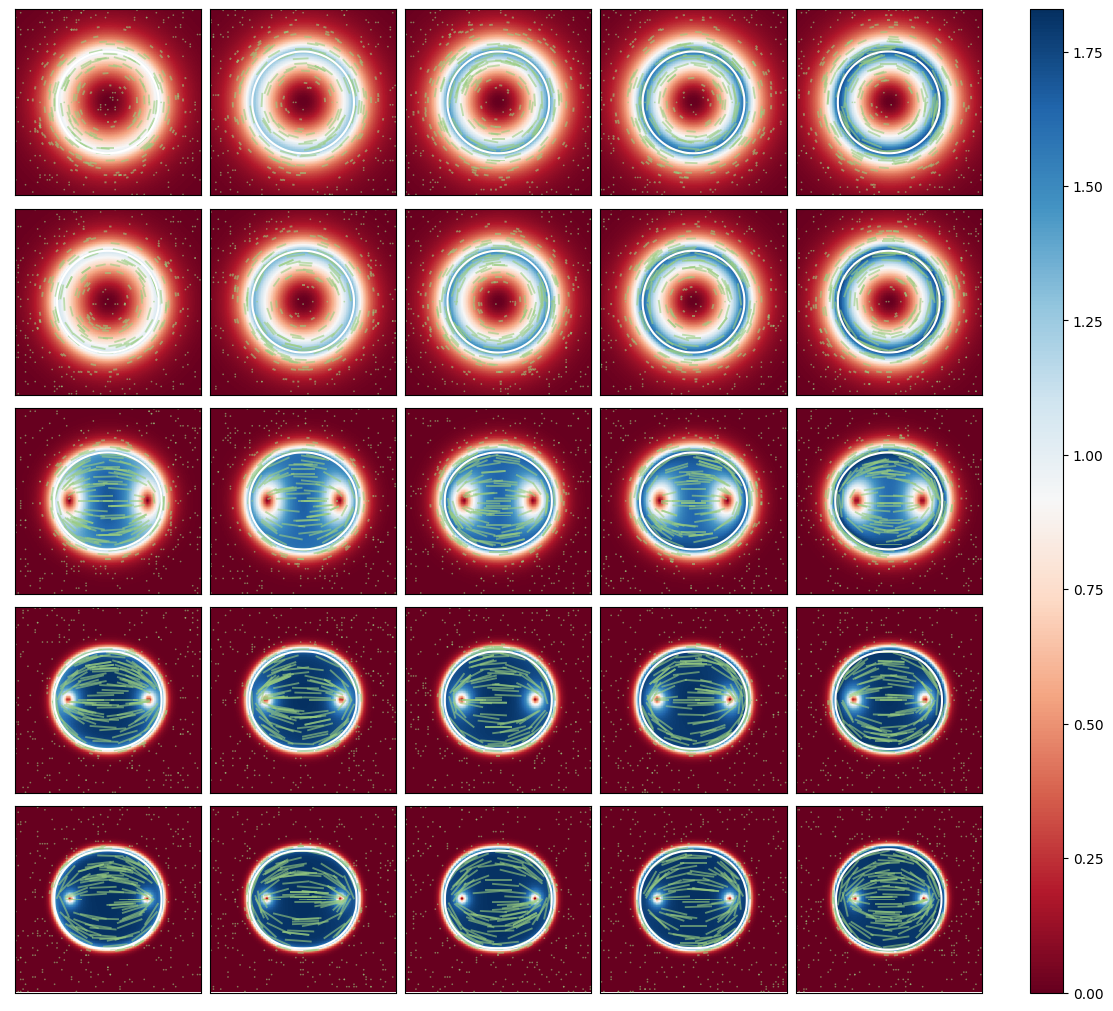

In [12]:
# Polar -> radial
c = LCConfig(N=N, lam=2e-7, epsr=.005, vol=.09,
                 wv=6e14, wphi=3e8, wa=9e8)
lams=[8e-7,1e-6,2e-6,5e-6,7.5e-6]
was=[3e8,6e8,9e8,1.5e9,3e9,4e9]
X=test_grid(c,lams,was,n_grid=5,out="p2r")
print(np.sum(X.phi/N**2))

Test 2 (tactoid to radial)

$w_p$=`3e7`, $\lambda$=`5e-7`~`9e-6`, $w_a$=`1e7~4e7`.

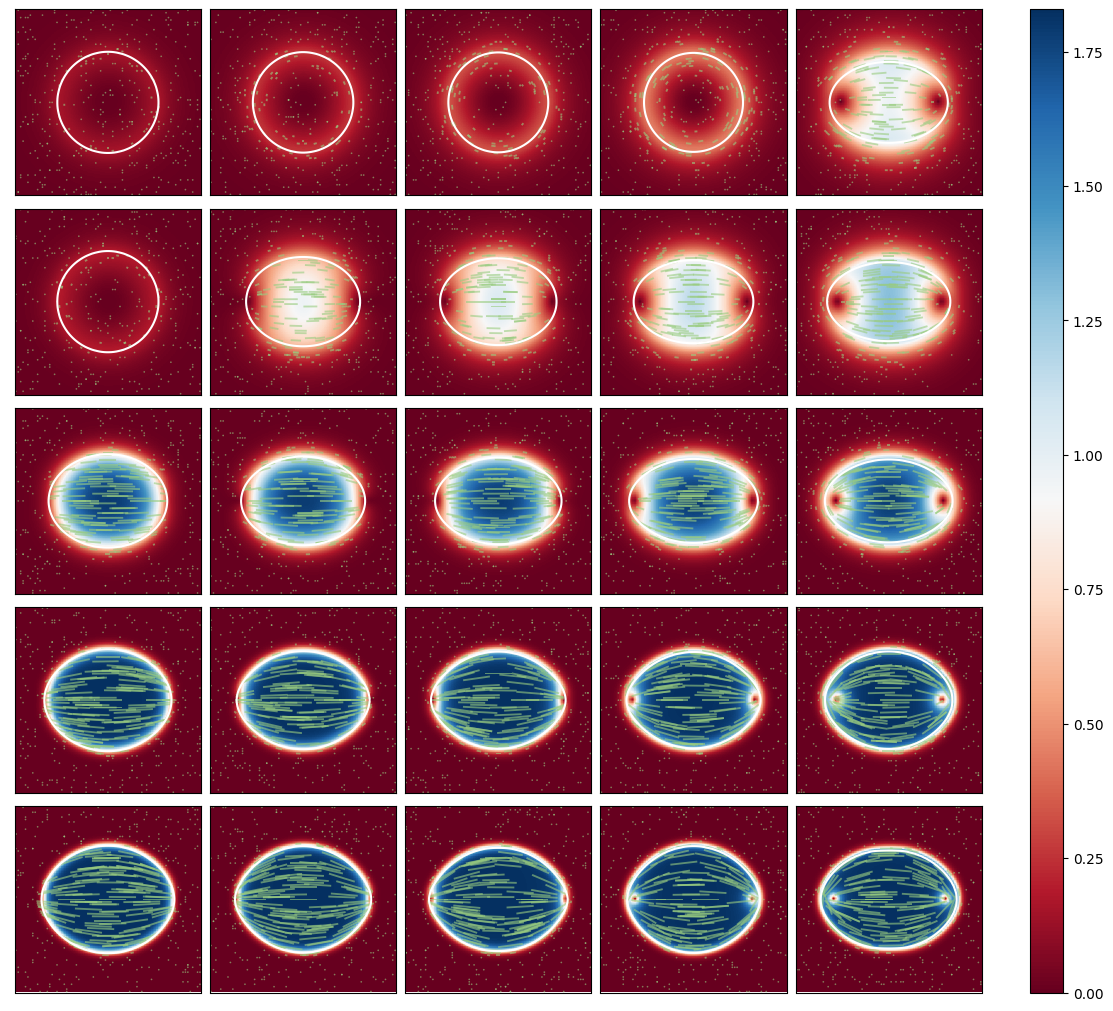

In [8]:
# Tactoid -> radial (weaker perimeter penalty)
c = LCConfig(N=N, lam=5e-6, epsr=.005, vol=.09,
                 wv=6e14, wphi=3e7, wa=6e7)
lams=[8e-7,1e-6,2e-6,5e-6,7.5e-6,9e-6]
was=[3e7,6e7,9e7,1.5e8,3e8,4e8]
X=test_grid(c,lams,was,n_grid=5,out="t2r")

Test 3 (polar, tactoid and radial)

$w_p$=`5e7`, $\lambda$=`3e-7`~`4e-6`, $w_a$=`1.5e7~4e8`.

In [9]:
# Run tests and plot on grid

# A different volume
# c = LCConfig(N=N, lam=5e-7, epsr=.005, vol=.09, wv=6e14, wphi=5e7, wa=1e8)
# lams=[3e-7,7e-7,9e-7,1.1e-6,2e-6,4e-6]
# was=[1.5e7,4e7,6e7,1.5e8,2.5e8,4e8]
# X=test_grid(c,lams,was,6,X0=X,out="p&t2r")
